In [1]:
%run Common.ipynb

!pip install autocorrect
from autocorrect import spell

In [2]:
import pandas as pd
import pytz
utc_tz = pytz.UTC
pst_tz = pytz.timezone('America/Los_Angeles')

In [3]:
import glob
basedir = 'data/ECE219_tweet_data/'

datafilenames = [i for i in glob.iglob(basedir + '*.txt')]
datafilenames

['data/ECE219_tweet_data\\tweets_#gohawks.txt',
 'data/ECE219_tweet_data\\tweets_#gopatriots.txt',
 'data/ECE219_tweet_data\\tweets_#nfl.txt',
 'data/ECE219_tweet_data\\tweets_#patriots.txt',
 'data/ECE219_tweet_data\\tweets_#sb49.txt',
 'data/ECE219_tweet_data\\tweets_#superbowl.txt']

In [4]:
'''
Instead of loading the entire file, you can read the files, line by line and keep the information you need.
Store the processed data in pickle objects.
'''
import json
import os

OVERWRITE_PICKLE_OBJECTS = False

def extract_feature_from_tweet(tweet_dict,feature_name):
    if feature_name == "tweet": 
        return tweet_dict["tweet"]["text"]
    if feature_name == "location":
        return tweet_dict["tweet"]["user"]["location"]
    if feature_name == "time_zone":
        return tweet_dict["tweet"]["user"]["time_zone"]
    return ""


feature_names = ["tweet", "location", "time_zone"]

for fn in log_progress(datafilenames):
    pickle_file = fn+'._15.pkl.gz'
    if os.path.isfile(pickle_file) and not OVERWRITE_PICKLE_OBJECTS:
        print(pickle_file+'\texists.')
    else:    
        tweets_features = dict() 
        for f in feature_names:
            tweets_features[f] = []
        
        with open(fn,'rb') as d:
            for ind, line in enumerate(d):      
                tweet_dict = json.loads(line) 
                for f in feature_names:
                    feature_value = extract_feature_from_tweet(tweet_dict, f)
                    tweets_features[f].append(feature_value)
        pickle_write(tweets_features, pickle_file)
        print(pickle_file+'\tsaved.')

data/ECE219_tweet_data\tweets_#gohawks.txt._15.pkl.gz	exists.
data/ECE219_tweet_data\tweets_#gopatriots.txt._15.pkl.gz	exists.
data/ECE219_tweet_data\tweets_#nfl.txt._15.pkl.gz	exists.
data/ECE219_tweet_data\tweets_#patriots.txt._15.pkl.gz	exists.
data/ECE219_tweet_data\tweets_#sb49.txt._15.pkl.gz	exists.
data/ECE219_tweet_data\tweets_#superbowl.txt._15.pkl.gz	exists.


In [5]:
hashtags = [f.split('#')[1].replace('.txt','') for f in datafilenames]
hashtags

['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl']

In [6]:
# load the extracted features
df_features = {}

for hashtag in log_progress(hashtags):
    tweet_features = pickle_load(basedir + 'tweets_#' + hashtag +'.txt._15.pkl.gz')
    df_features[hashtag] = pd.DataFrame(tweet_features)

In [7]:
df_features['superbowl'].head()

location                   time_zone  \
0                                    None   
1  k-town Ak.                        None   
2      Brazil                Mid-Atlantic   
3        Iowa                        None   
4     Cloud 9  Central Time (US & Canada)   

                                               tweet  
0  At http://t.co/Vd0RWOeAed -- #Seahawks #12thMA...  
1  You been 12ed pass it on #SeahawkNation #LOB #...  
2  27 days to the SuperBowl 🏈🏈\n#Katyperry #KatyC...  
3  Check out the cool event that  #budlight has p...  
4  Lenny Kravitz acompañará a Katy Perry en el #H...

In [8]:
%%script false

from sklearn.feature_extraction.text import CountVectorizer
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

wnl = nltk.wordnet.WordNetLemmatizer()

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

analyzer = CountVectorizer().build_analyzer()

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def lemmatize_rmv_numeric(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not is_number(word))

# Question 15

## Extracting WA or MA Data

In [9]:
washington_keywords = set(['seattle', 'wa', 'washington', 'wash'])
washington_keywords

{'seattle', 'wa', 'wash', 'washington'}

In [10]:
mass_keywords = set(['massachusetts', 'ma', 'boston'])
mass_keywords

{'boston', 'ma', 'massachusetts'}

In [11]:
def is_wa_or_ma(location):
    if location.strip() == '':
        return (False, False)
    loc_lemma = set([spell(i).lower() for i in lemmatize_rmv_numeric(location)])
    is_wash = len(loc_lemma.intersection(washington_keywords)) >= 1
    is_mass = len(loc_lemma.intersection(mass_keywords)) >= 1
    if is_wash:
        fixed_location = location.lower().strip()
        if fixed_location.endswith('dc') or fixed_location.endswith('d.c.'):
            is_wash = False
    return (is_wash, is_mass)

In [12]:
is_wa_or_ma('washington, dc')

(False, False)

In [13]:
is_wa_or_ma('')

(False, False)

In [14]:
is_wa_or_ma('washington/boston')

(True, True)

In [15]:
OVERWRITE_PICKLE_OBJECTS - False

pickle_file = 'q15_df_sb.pkl.gz'
if os.path.isfile(pickle_file) and not OVERWRITE_PICKLE_OBJECTS:
    df_sb = pickle_load(pickle_file)
    print(pickle_file+'\texists.')
else: 
    df_sb = df_features['superbowl']
    iswa = []
    isma = []
    for l in log_progress(df_sb['location']):
        is_wash, is_mass = is_wa_or_ma(l)
        iswa.append(is_wash)
        isma.append(is_mass)
    df_sb['is_wa'] = iswa
    df_sb['is_ma'] = isma
    pickle_write(df_sb, pickle_file)

q15_df_sb.pkl.gz	exists.


In [16]:
df_sb.shape

(1213813, 5)

In [17]:
# see if there are locations with both
idx_both = df_sb[(df_sb.is_wa) & (df_sb.is_ma)].index
idx_both

Int64Index([  10104,   13514,   21835,   38484,   51661,   53391,   62240,
              65064,   66253,   97343,  138220,  143632,  144100,  148034,
             155434,  213460,  248199,  252757,  379243,  457294,  469421,
             490488,  557804,  673763,  675750,  716346,  716873,  718936,
             723322,  772087,  792429,  793247,  822848,  824320,  907891,
             986223,  998077, 1105354, 1122880, 1141661, 1141683, 1163908,
            1196222],
           dtype='int64')

In [18]:
df_sb.drop(idx_both, inplace=True)
df_sb.shape

(1213770, 5)

### Prune non-WA or non-MA

In [19]:
# get only tweets that are in WA or MA
df_sb_wa_ma = df_sb[(df_sb.is_wa) | (df_sb.is_ma)]

In [20]:
df_sb_wa_ma.shape

(41969, 5)

# Question 16

## Lemmatize the Tweet data

In [21]:
OVERWRITE_PICKLE_OBJECTS - False

pickle_file = 'q15_tweets_lemmatized.pkl.gz'
if os.path.isfile(pickle_file) and not OVERWRITE_PICKLE_OBJECTS:
    tweets_lemmatized = pickle_load(pickle_file)
    print(pickle_file+'\texists.')
else: 
    tweets_lemmatized = []
    for tweet in log_progress(df_sb_wa_ma.tweet):
        tweets_lemmatized.append(" ".join(list(lemmatize_rmv_numeric(tweet))))
    pickle_write(tweets_lemmatized, pickle_file)

q15_tweets_lemmatized.pkl.gz	exists.


In [22]:
tweets_lemmatized[0:10]

['our butchstearns talk patriot 3x superbowl champ matt light full interview http co 6s9xquucyj fox25 http co itafnwqc2g',
 'mondaymotivation gohawks seahawks superbowlbound bodypaint happy monday lt http co md0vghp72k',
 'interview with the seattle seahawks superbowl champion http co 4hs6dyeoxv gohawks superbowlxlviii nfl espn',
 'dougbaldwinjr just this mediocre superbowlchampion wide receiver gohawks repete http co huwzhg6jwq video http co we4pp5yahd',
 'just superbowlchampion pedestrian wide receiver gohawks repete http co huwzhg6jwq video http co xyqxeg6u6k',
 'jc_nogales sunday february 1st se juega en arizona superbowlxlix',
 'interview with the seattle seahawks superbowl champion http co zuojg0uznr gohawks superbowlxlviii nfl espn',
 'katyperry you have to play your lose your love remix at superbowlxlix scottzolak greshandzo josie patriotsnation patriot',
 'no offense katy perry but we hope this be joke http co vn3hljaocr sb2015 halftimesuperbowl katyperry superbowlxlix',
 'sea

In [23]:
df_sb_wa_ma.tweet[0:10]

6      Our @ButchStearns talked #Patriots w/3X #Super...
9      #MondayMotivation #GOHAWKS #SEAHAWKS #superbow...
26     Interview With the Seattle Seahawks Superbowl ...
29     @DougBaldwinJr just this #mediocre #SuperBowlC...
31     Just a #SuperBowlChampion  #Pedestrian wide re...
62     @jc_nogales Sunday February 1st. Se juega en A...
87     Interview With the Seattle Seahawks Superbowl ...
102    @katyperry You have to play your "Lose Your Lo...
122    No offense Katy Perry but we hope this is a JO...
139    Seattle #Seahawks #LegionofBoom Youth Tee #Sup...
Name: tweet, dtype: object

## Assign Classes

In [24]:
location_classes = []
for index, row in df_sb_wa_ma.iterrows():
    location_classes.append(0 if row.is_wa else 1)

In [25]:
location_classes[0:10]

[1, 0, 0, 0, 0, 1, 0, 1, 0, 0]

In [26]:
df_sb_wa_ma[['is_wa', 'is_ma']][0:10]

is_wa  is_ma
6    False   True
9     True  False
26    True  False
29    True  False
31    True  False
62   False   True
87    True  False
102  False   True
122   True  False
139   True  False

## Grid Search

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Multiprocessing doesn't work on Windows!
n_jobs = 8
import platform
if platform.system() in ['Windows', 'Darwin']:
    n_jobs = 1

In [28]:
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=0)

pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
],
memory=memory
)

In [29]:
param_grid = [
    {   # Linear SVM Classifier
        'vect__min_df': [3, 5],                           # Feature Extraction:       min_df = 3 vs 5
        'reduce_dim': [TruncatedSVD(), NMF()],            # Dimensionality Reduction: LSI vs NMF
        'reduce_dim__random_state': [0],                  # Fixed random_state
        'reduce_dim__n_components': [50],                 # Fixed to 50 components
        'clf': [LinearSVC()],                    
        'clf__C': [10]                                    # Q4: best gamma is 10
    },
    {   # Logistic Regression
        'vect__min_df': [3, 5],                           # Feature Extraction:       min_df = 3 vs 5
        'reduce_dim': [TruncatedSVD(), NMF()],            # Dimensionality Reduction: LSI vs NMF
        'reduce_dim__random_state': [0],                  # Fixed random_state
        'reduce_dim__n_components': [50],                 # Fixed to 50 components
        'clf': [LogisticRegression()],                
        'clf__C': [10],                                   # Q5: Best regularization strength for L1 and L2 is 10
        'clf__penalty': ['l1', 'l2']                      # L1 regularization vs L2 regularization
    },
    {   # Gaussian Naive Bayes
        'vect__min_df': [3, 5],                           # Feature Extraction:       min_df = 3 vs 5
        'reduce_dim': [TruncatedSVD(), NMF()],            # Dimensionality Reduction: LSI vs NMF
        'reduce_dim__random_state': [0],                  # Fixed random_state
        'reduce_dim__n_components': [50],                 # Fixed to 50 components
        'clf': [GaussianNB()]
    },
]

In [30]:
X_train = tweets_lemmatized
y_train = location_classes

In [31]:
grid = GridSearchCV(pipeline, cv=5, n_jobs=n_jobs, param_grid=param_grid, scoring='accuracy', return_train_score=False, verbose=1)
%time grid.fit(X_train, y_train)
rmtree(cachedir)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.8min finished


Wall time: 5min 6s


In [32]:
type(grid.best_estimator_._final_estimator) == LogisticRegression

True

<h3>Grid Search Result</h3>

In [33]:
df_grid = pd.DataFrame(grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
df_grid

mean_fit_time  mean_score_time  mean_test_score  \
10       0.516881         0.175114         0.746575   
6        0.481356         0.174037         0.745955   
7        0.477022         0.175126         0.745812   
2       21.914992         0.193786         0.745789   
11       0.495841         0.174160         0.745479   
3       16.973234         0.195832         0.745121   
5        0.782219         0.081088         0.742405   
9        0.731436         0.085091         0.742381   
8        0.699513         0.087279         0.741500   
4        0.817422         0.083976         0.741357   
1        5.023110         0.081980         0.741023   
0        5.318721         0.086476         0.740833   
14       0.404427         0.185588         0.699397   
15       0.371249         0.190190         0.695680   
12       0.384022         0.097724         0.655436   
13       0.384374         0.089987         0.654078   

                                            param_clf param_clf__C  \
10  LogisticRegression(C=10, class_weight=None, du...           10   
6   LogisticRegression(C=10, class_weight=None, du...           10   
7   LogisticRegression(C=10, class_weight=None, du...           10   
2   LinearSVC(C=10, class_weight=None, dual=True, ...           10   
11  LogisticRegression(C=10, class_weight=None, du...           10   
3   LinearSVC(C=10, class_weight=None, dual=True, ...           10   
5   LogisticRegression(C=10, class_weight=None, du...           10   
9   LogisticRegression(C=10, class_weight=None, du...           10   
8   LogisticRegression(C=10, class_weight=None, du...           10   
4   LogisticRegression(C=10, class_weight=None, du...           10   
1   LinearSVC(C=10, class_weight=None, dual=True, ...           10   
0   LinearSVC(C=10, class_weight=None, dual=True, ...           10   
14                            GaussianNB(priors=None)          NaN   
15                            GaussianNB(priors=None)          NaN   
12                            GaussianNB(priors=None)          NaN   
13                            GaussianNB(priors=None)          NaN   

   param_clf__penalty                                   param_reduce_dim  \
10                 l2  NMF(alpha=0.0, beta_loss='frobenius', init=Non...   
6                  l1  NMF(alpha=0.0, beta_loss='frobenius', init=Non...   
7                  l1  NMF(alpha=0.0, beta_loss='frobenius', init=Non...   
2                 NaN  NMF(alpha=0.0, beta_loss='frobenius', init=Non...   
11                 l2  NMF(alpha=0.0, beta_loss='frobenius', init=Non...   
3                 NaN  NMF(alpha=0.0, beta_loss='frobenius', init=Non...   
5                  l1  TruncatedSVD(algorithm='randomized', n_compone...   
9                  l2  TruncatedSVD(algorithm='randomized', n_compone...   
8                  l2  TruncatedSVD(algorithm='randomized', n_compone...   
4                  l1  TruncatedSVD(algorithm='randomized', n_compone...   
1                 NaN  TruncatedSVD(algorithm='randomized', n_compone...   
0                 NaN  TruncatedSVD(algorithm='randomized', n_compone...   
14                NaN  NMF(alpha=0.0, beta_loss='frobenius', init=Non...   
15                NaN  NMF(alpha=0.0, beta_loss='frobenius', init=Non...   
12                NaN  TruncatedSVD(algorithm='randomized', n_compone...   
13                NaN  TruncatedSVD(algorithm='randomized', n_compone...   

   param_reduce_dim__n_components param_reduce_dim__random_state  \
10                             50                              0   
6                              50                              0   
7                              50                              0   
2                              50                              0   
11                             50                              0   
3                              50                              0   
5                              50                              0   
9                              50       

<h3>Best Estimators</h3>
<p>Find best estimators for each type.</p>

In [34]:
lr_estimators = df_grid[[type(clf) == LogisticRegression for clf in df_grid.param_clf]]
best_lr = lr_estimators.head(1).param_clf.values[0]
print(str(best_lr))
print("TfidfVectorizer(min_df=%d)" %lr_estimators.head(1).param_vect__min_df.values[0])
print(str(lr_estimators.head(1).param_reduce_dim.values[0]))

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
TfidfVectorizer(min_df=3)
NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)


In [35]:
svc_estimators = df_grid[[type(clf) == LinearSVC for clf in df_grid.param_clf]]
best_svc = svc_estimators.head(1).param_clf.values[0]
print(str(best_svc))
print("TfidfVectorizer(min_df=%d)" %svc_estimators.head(1).param_vect__min_df.values[0])
print(str(svc_estimators.head(1).param_reduce_dim.values[0]))

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
TfidfVectorizer(min_df=3)
NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)


In [36]:
gnb_estimators = df_grid[[type(clf) == GaussianNB for clf in df_grid.param_clf]]
best_gnb = gnb_estimators.head(1).param_clf.values[0]
print(str(best_gnb))
print("TfidfVectorizer(min_df=%d)" %gnb_estimators.head(1).param_vect__min_df.values[0])
print(str(gnb_estimators.head(1).param_reduce_dim.values[0]))

GaussianNB(priors=None)
TfidfVectorizer(min_df=3)
NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)


## ROC Curve, Confusion Matrix, Accuracy, Recall, Precision

In [37]:
%matplotlib inline

#function from project 1
def fit_predict_and_plot(clf, train_data, train_labels, test_data, test_labels, class_names):
    clf.fit(train_data, train_labels)

    prob = clf.decision_function(test_data)
    pred = clf.predict(test_data)

    fpr, tpr, _ = roc_curve(test_labels, prob)

    plot_roc(fpr, tpr)
    
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    print_scores(test_labels, pred)
    
    return clf

In [38]:
#all 3 models have same best params
reduction_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=3, stop_words = 'english')),
    ('reduce_dim', NMF(n_components=50, random_state=0))
])

# datasets are already lemmatized, so no lemmatization needed here

%time X_train_reduced = reduction_pipeline.fit_transform(X_train, y_train)

#0: Washington, 1: Massacusetts
class_names = ['Washington', 'Massachusetts']

Wall time: 15.2 s


## Logistic Regression

Confusion matrix, without normalization
[[11748  8296]
 [ 1271 20654]]
Normalized confusion matrix
[[0.59 0.41]
 [0.06 0.94]]
accuracy:0.7720460339774595
precision:0.7134369602763385
recall:0.9420296465222349
f1:0.81195085995086


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

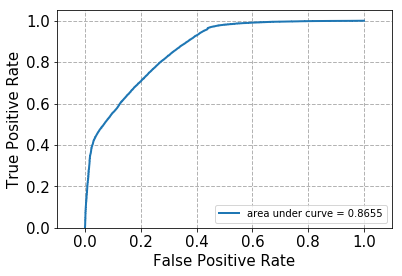

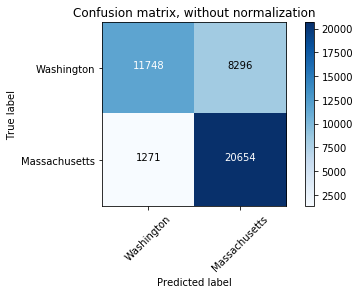

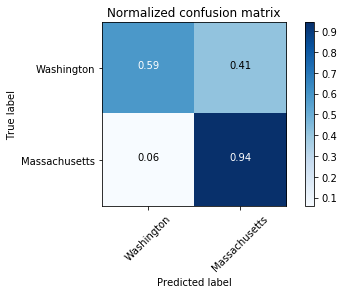

In [39]:
clf = best_lr
fit_predict_and_plot(clf, X_train_reduced, y_train, X_train_reduced, y_train, class_names)

## Linear SVM

Confusion matrix, without normalization
[[11750  8294]
 [ 1266 20659]]
Normalized confusion matrix
[[0.59 0.41]
 [0.06 0.94]]
accuracy:0.7722128237508638
precision:0.7135357303215556
recall:0.9422576966932725
f1:0.8120995322143166


LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

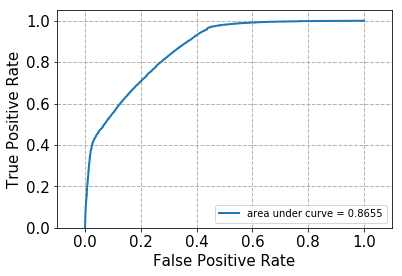

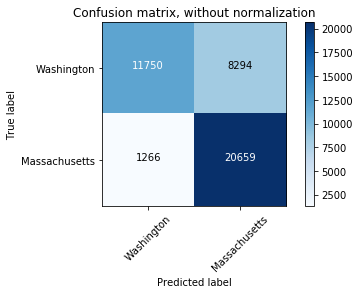

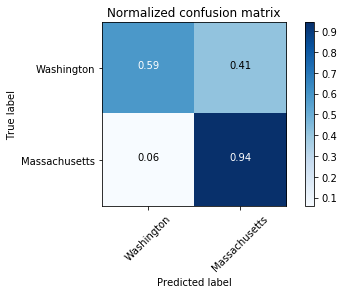

In [40]:
clf = best_svc
fit_predict_and_plot(clf, X_train_reduced, y_train, X_train_reduced, y_train, class_names)

## Gaussian Naive Bayes

In [41]:
def gnb_fit_predict_and_plot(clf, train_data, train_labels, test_data, test_labels, class_names):
    clf.fit(train_data, train_labels)

    prob = clf.predict_proba(test_data)
    pred = clf.predict(test_data)

    fpr, tpr, _ = roc_curve(test_labels, prob[:,1])

    plot_roc(fpr, tpr)
    
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    print_scores(test_labels, pred)
    
    return clf

Confusion matrix, without normalization
[[13233  6811]
 [ 3774 18151]]
Normalized confusion matrix
[[0.66 0.34]
 [0.17 0.83]]
accuracy:0.7477900355023946
precision:0.7271452607964105
recall:0.8278677309007981
f1:0.7742444600848849


GaussianNB(priors=None)

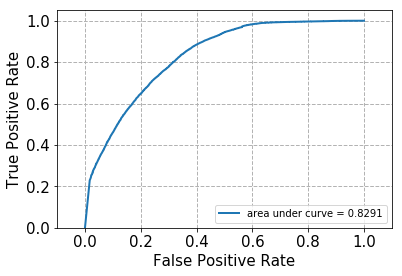

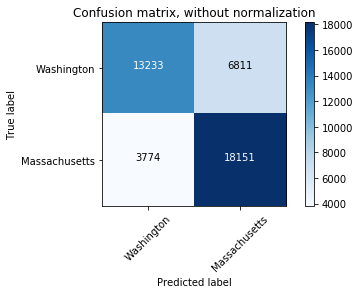

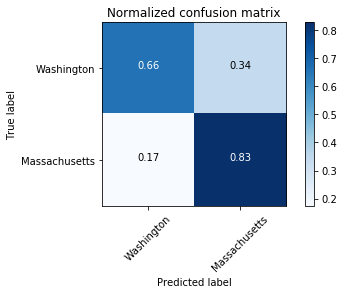

In [42]:
clf = best_gnb
gnb_fit_predict_and_plot(clf, X_train_reduced, y_train, X_train_reduced, y_train, class_names)